In [1]:
import os
import cv2
import glob
import random
import warnings
import numpy as np
import disarray as da
import seaborn as sns
import tensorflow as tf
from imutils import paths
from itertools import cycle
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input

/home/sanjeev/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#base_path = '/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/Plots/X.npy'' # Data Path 
base_path = '/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/asm_images/'
img_list = glob.glob(os.path.join(base_path, '*/*.png'))

In [3]:
categories = os.listdir(base_path)
labels = [i for i in range(len(categories))]
label_dict = dict(zip(categories, labels))

In [4]:
cur_dir = os.getcwd()
os.chdir(base_path)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family

for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
fam = []
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
        fam.append(list_fams[label])
    label += 1
num_classes = label

Label: 0	Family:           Gatak	Number of images: 1013
Label: 1	Family:    Kelihos_ver1	Number of images: 398
Label: 2	Family:    Kelihos_ver3	Number of images: 2942
Label: 3	Family:        Lollipop	Number of images: 2478
Label: 4	Family:  Obfuscator.ACY	Number of images: 1228
Label: 5	Family:          Ramnit	Number of images: 1541
Label: 6	Family:           Simda	Number of images: 42
Label: 7	Family:          Tracur	Number of images: 751
Label: 8	Family:           Vundo	Number of images: 475


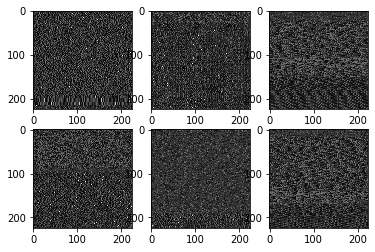

In [5]:
# Sample images from dataset
for i, img_path in enumerate(random.sample(img_list, 6)):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img, dtype=np.uint8)
    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

In [6]:
# feature extraction
IMG_SHAPE = (224,224,3) # Input image shape
base_model = tf.keras.applications.mobilenet.MobileNet(input_shape=IMG_SHAPE,
                                                       include_top=False,      # Discarding top layer of architecture 
                                                       pooling ='avg',
                                                       weights='imagenet')

In [7]:
model = tf.keras.Sequential([base_model, tf.keras.layers.Dense(1024, activation='relu')])
                                                                                    # Applying keras sequential layer to 
                                                                                    # base model with relu activation to 
                                                                                    # extract only features from images 
                                                                                    # without making prediction
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 1024)             3228864   
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
Total params: 4,278,464
Trainable params: 4,256,576
Non-trainable params: 21,888
_________________________________________________________________


In [8]:
bytes_features = np.load('/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/Plots/MobileNetV1_feat_bytes_microsoft_1024.npy')
asm_features = np.load('/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/Plots/MobileNetV1_feat_asm_microsoft_1024.npy')

In [9]:
bytes_features.shape, asm_features.shape

((10868, 1024), (10868, 1024))

In [10]:
X = []
for i in range(len(bytes_features)):
    x = list(np.hstack((bytes_features[i], asm_features[i])))
    X.append(x)

In [11]:
X =  np.array(X)
X.shape

(10868, 2048)

In [12]:
import pandas as pd
import disarray as da
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, matthews_corrcoef, roc_curve, auc

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.21, random_state=42)

In [14]:
print("X_Train:", X_train.shape)
print("Y_Train:", y_train.shape)
print("X_Test:", X_test.shape)
print("Y_Test:", y_test.shape)

X_Train: (8585, 2048)
Y_Train: (8585,)
X_Test: (2283, 2048)
Y_Test: (2283,)


In [15]:
rf =  RandomForestClassifier()

In [16]:
%%time
rf.fit(X_train,y_train)

CPU times: user 21.5 s, sys: 0 ns, total: 21.5 s
Wall time: 21.5 s


RandomForestClassifier()

In [17]:
print("Testing Accuracy:", round((rf.score(X_test, y_test) * 100), 2))

Testing Accuracy: 91.68


In [18]:
%%time
y_pred = rf.predict(X_test)

CPU times: user 82.3 ms, sys: 292 µs, total: 82.6 ms
Wall time: 81.1 ms


In [19]:
%%time
ls = precision_recall_fscore_support(y_test, y_pred, average='micro')
print(int(round(ls[0]*100, 0)), int(round(ls[1]*100, 0)), int(round(ls[2]*100, 0)))

92 92 92
CPU times: user 0 ns, sys: 4.58 ms, total: 4.58 ms
Wall time: 3.55 ms


In [20]:
accuracy_score(y_pred,y_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95       214
         1.0       0.89      0.99      0.94        73
         2.0       0.99      1.00      1.00       618
         3.0       0.94      0.85      0.89       557
         4.0       0.91      1.00      0.95       222
         5.0       0.83      0.82      0.83       336
         6.0       0.14      1.00      0.25         1
         7.0       0.76      0.76      0.76       156
         8.0       0.95      1.00      0.97       106

    accuracy                           0.92      2283
   macro avg       0.82      0.93      0.84      2283
weighted avg       0.92      0.92      0.92      2283



## Grid search

In [21]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [22]:
%%time
# Perform cross-validation and grid search to find the best hyperparameters
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')

CPU times: user 124 µs, sys: 18 µs, total: 142 µs
Wall time: 162 µs


In [23]:
%%time
grid_search.fit(X_train, y_train)

CPU times: user 9h 33s, sys: 12.5 s, total: 9h 46s
Wall time: 9h 53s


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [24]:
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [26]:
%%time
print("Accuracy on testing set: {:.4f}".format(grid_search.score(X_test, y_test)))

Accuracy on testing set: 0.9203
CPU times: user 337 ms, sys: 32 ms, total: 369 ms
Wall time: 367 ms


In [26]:
y_pred = grid_search.predict(X_test)
print("Classification report:\n", classification_report(y_test, y_pred))

Classification report:
               precision    recall  f1-score   support

         0.0       0.97      0.89      0.93       219
         1.0       0.99      0.86      0.92        81
         2.0       1.00      0.99      1.00       624
         3.0       0.83      0.93      0.88       507
         4.0       1.00      0.88      0.94       245
         5.0       0.76      0.84      0.80       332
         6.0       0.00      0.00      0.00         7
         7.0       0.76      0.67      0.71       156
         8.0       1.00      0.91      0.95       112

    accuracy                           0.90      2283
   macro avg       0.81      0.77      0.79      2283
weighted avg       0.90      0.90      0.90      2283



In [27]:
list_fams = sorted(label_dict.keys())

In [28]:
classification_metrices = metrics.classification_report(y_test, y_pred, output_dict=True, target_names= list_fams)
df = pd.DataFrame(classification_metrices).transpose()
df.to_csv('/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/Experiment_3/plots/MobileNet_V1_RandomForest_st.csv')

Plotting the confusion matrix


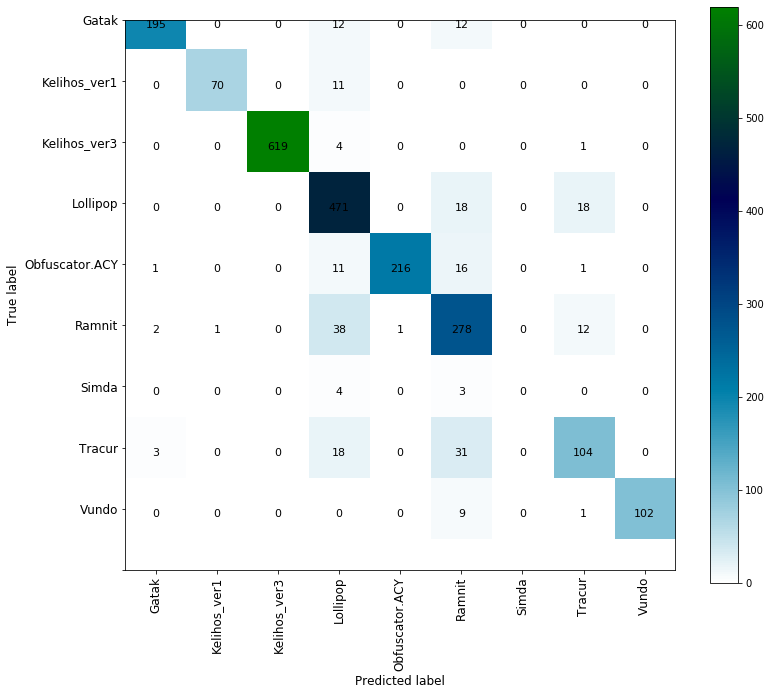

In [29]:
conf_matrix = confusion_matrix(y_test, y_pred)

print("Plotting the confusion matrix")
conf_mat = np.around(conf_matrix, decimals=2)  
figure = plt.gcf()
figure.set_size_inches(11, 10)
plt.imshow(conf_mat, interpolation='nearest', cmap='ocean_r')

for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat[row][col]), xy=(col,row), ha='center', va='top', fontsize=11)
        
plt.xticks(range(len(list_fams)), list_fams, rotation=90, fontsize=12)
plt.yticks(range(len(list_fams)+1), list_fams, fontsize=12)

plt.ylabel('True label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)

plt.tight_layout()
plt.colorbar()
plt.savefig('/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/Experiment_3/plots/MobileNet_V1_RandomForest_st.eps', bbox_inches='tight')
plt.savefig('/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/Experiment_3/plots/MobileNet_V1_RandomForest_st.png', bbox_inches='tight')

plt.show()

In [30]:
cm = confusion_matrix(y_test, y_pred)
df = pd.DataFrame(cm)

In [31]:
pd.set_option('display.max_columns', None)  # force to display any number of columns.

In [32]:
#calculating true positives, false positives, true negatives and false negatives from confusion matrix
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

In [33]:
FP, FN, TP, TN

(array([ 6,  1,  0, 98,  1, 89,  0, 33,  0]),
 array([24, 11,  5, 36, 29, 54,  7, 52, 10]),
 array([195,  70, 619, 471, 216, 278,   0, 104, 102]),
 array([2058, 2201, 1659, 1678, 2037, 1862, 2276, 2094, 2171]))

In [34]:
#calculating false_omission_rate
NPV = TN/(TN+FN)
FOR = 1-NPV
FOR

array([0.01152738, 0.00497288, 0.00300481, 0.0210035 , 0.01403679,
       0.02818372, 0.00306614, 0.02423113, 0.00458505])

In [35]:
data = df.da.export_metrics(metrics_to_include=['true_positive_rate', 'true_negative_rate', 'false_positive_rate', 
                                              'false_negative_rate', 'false_discovery_rate'])

In [36]:
for num, fam in zip(range(25), list_fams):
    data.rename(columns={data.columns[num]:fam}, inplace=True)

data1 = data.drop(columns=['micro-average'])
data1 = data1.T
# data.drop(df.tail(1).index,inplace=True)

data1['false_omission_rate'] = list(FOR)

data1

,true_positive_rate,true_negative_rate,false_positive_rate,false_negative_rate,false_discovery_rate,false_omission_rate
Gatak,0.890411,0.997093,0.002907,0.109589,0.029851,0.011527
Kelihos_ver1,0.864198,0.999546,0.000454,0.135802,0.014085,0.004973
Kelihos_ver3,0.991987,1.000000,0.000000,0.008013,0.000000,0.003005
Lollipop,0.928994,0.944820,0.055180,0.071006,0.172232,0.021004
Obfuscator.ACY,0.881633,0.999509,0.000491,0.118367,0.004608,0.014037
Ramnit,0.837349,0.954382,0.045618,0.162651,0.242507,0.028184
Simda,0.000000,1.000000,0.000000,1.000000,NaN,0.003066
Tracur,0.666667,0.984485,0.015515,0.333333,0.240876,0.024231
Vundo,0.910714,1.000000,0.000000,0.089286,0.000000,0.004585


In [37]:
for i in data1:
    print('Average of', i, '-->', round((np.average(data1[i])*100), 4))

Average of true_positive_rate --> 77.4661
Average of true_negative_rate --> 98.6648
Average of false_positive_rate --> 1.3352
Average of false_negative_rate --> 22.5339
Average of false_discovery_rate --> nan
Average of false_omission_rate --> 1.2735


In [38]:
#MCC value
print('MCC Score:', round(matthews_corrcoef(y_test, y_pred), 2))

MCC Score: 0.88


In [39]:
print("micro_precision :", metrics.precision_score(y_test, y_pred, average='micro'))
print("micro_recall :", metrics.recall_score(y_test, y_pred, average='micro'))
print("micro_f1_score :", metrics.f1_score(y_test, y_pred, average='micro'))

micro_precision : 0.900131406044678
micro_recall : 0.900131406044678
micro_f1_score : 0.900131406044678


In [40]:
print("macro_precision :", metrics.precision_score(y_test, y_pred, average='macro'))
print("macro_recall :", metrics.recall_score(y_test, y_pred, average='macro'))
print("macro_f1_score :", metrics.f1_score(y_test, y_pred, average='macro'))

macro_precision : 0.8106490823800121
macro_recall : 0.7746614172364734
macro_f1_score : 0.7905246470573533


In [41]:
enc = OneHotEncoder()
enc.fit(y_train.reshape(-1, 1))  
y_test = enc.transform(y_test.reshape(-1, 1))
y_pred = enc.transform(y_pred.reshape(-1, 1))

In [42]:
y_test = y_test.toarray()
y_pred = y_pred.toarray()

In [43]:
n_classes = 9

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

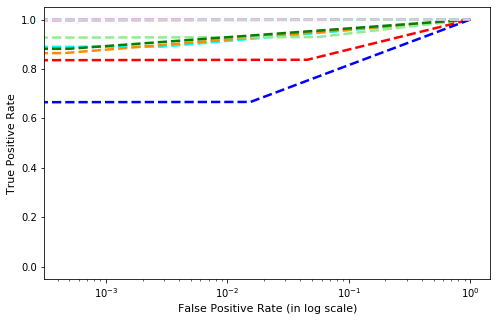

In [44]:
# Compute macro-average ROC curve and ROC area

n_classes = 9
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw = 2.5   # line width
plt.figure(figsize=(8,5))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'lightgreen', 'green', 'red', 'cyan', 'blue', 
                 'pink', 'purple', 'brown', 'coral', 'chocolate', 'indigo', 'navy'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, linestyle='dashed', lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.xscale("log")
plt.xlabel('False Positive Rate (in log scale)', fontsize=11)
plt.ylabel('True Positive Rate', fontsize=11)
plt.savefig("/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/Experiment_3/plots/mobilenetV1_microsoft_roc_RandomForest_st.eps", bbox_inches='tight')
plt.savefig("/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/Experiment_3/plots/mobilenetV1_microsoft_roc_RandomForest_st.png", bbox_inches='tight')

plt.show()